Enter Stock Ticker: amc
               Close   Predict
Date                          
2020-01-02  7.414512  7.056707
2020-01-03  7.275366  6.997073
2020-01-06  7.076585  7.265427
2020-01-07  7.086524  7.712683
2020-01-08  6.579634  7.414512
...              ...       ...
2021-01-14  2.180000  9.180000
2021-01-15  2.330000  8.930000
2021-01-19  3.060000  8.580000
2021-01-20  2.970000  8.030000
2021-01-21  2.980000  8.050000

[266 rows x 2 columns]


<ipython-input-1-54170e8ec814>:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predict'] = predictions


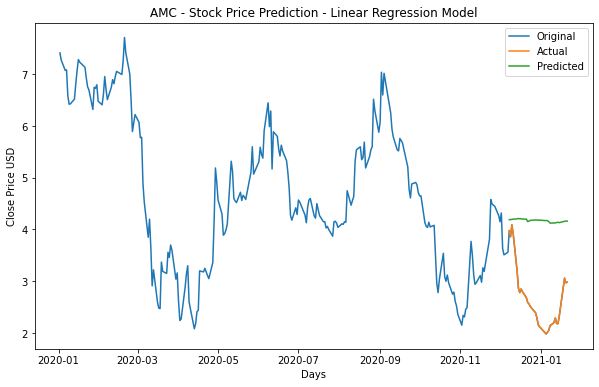

<ipython-input-1-54170e8ec814>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predict'] = predictions


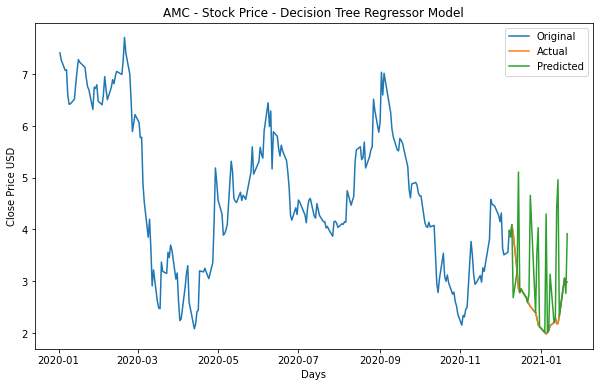

               Close     Volume Predict  SM1  SM2  SM3  SM4
Date                                                       
2020-01-02  7.414512  4545900.0     NaN  NaN  NaN  NaN  NaN
2020-01-03  7.275366  2218000.0     NaN  NaN  NaN  NaN  NaN
2020-01-06  7.076585  2903400.0     NaN  NaN  NaN  NaN  NaN
2020-01-07  7.086524  3205300.0     NaN  NaN  NaN  NaN  NaN
2020-01-08  6.579634  6557000.0     NaN  NaN  NaN  NaN  NaN
...              ...        ...     ...  ...  ...  ...  ...
2021-03-15       NaN        NaN     NaN  NaN  NaN  NaN  NaN
2021-03-16       NaN        NaN     NaN  NaN  NaN  NaN  NaN
2021-03-17       NaN        NaN     NaN  NaN  NaN  NaN  NaN
2021-03-18       NaN        NaN     NaN  NaN  NaN  NaN  NaN
2021-03-19       NaN        NaN     NaN  NaN  NaN  NaN  NaN

[306 rows x 7 columns]


In [1]:
import pandas as pd    
import numpy as np
import matplotlib.pyplot as plt 
from pandas_datareader.data import DataReader
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

beginDate ='2020-01-01'
endDate = datetime.datetime.now().date()     
#
#df = pd.read_csv('XXXXXX.csv',index_col=0)
# note: if using line above, loading from csv, comment out section below
#
# User input and load ticker data from yahoo finance
while True:
    try: 
        ticker = input('Enter Stock Ticker: ').upper()
        df = DataReader(ticker, 'yahoo', beginDate, endDate)
    except:
        print('\nStock Ticker Symbol does not exist!\n')
        continue;
    break
#
# Use Adj Close instead of Close
df['Close'] = df['Adj Close']
df = df.drop('Adj Close', axis=1)
df = df.drop('High', axis=1)
df = df.drop('Low', axis=1)
df = df.drop('Open', axis=1)

# Future Days - number of days to predict
modelData = df['Close'].to_frame()
futureDays = 30
modelData['Predict'] = modelData['Close'].shift(-futureDays)
modelData = modelData.dropna()
print(modelData)
x = np.array(modelData.drop(['Predict'], 1))[:-futureDays]
#print(x)
y = np.array(modelData['Predict'])[:-futureDays]
#print(y)
#
# Split data 75% training, 25% testing
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25)
tree = DecisionTreeRegressor().fit(xtrain, ytrain)
linear = LinearRegression().fit(xtrain, ytrain)
xfuture = modelData.drop(['Predict'], 1)[:-futureDays]
xfuture = xfuture.tail(futureDays)
xfuture = np.array(xfuture)
#
# Decision Tree and Linear Regression models
treePrediction = tree.predict(xfuture)
#print('Decision Tree prediction =',treePrediction)
linearPrediction = linear.predict(xfuture)
#print('Linear Regression prediction =',linearPrediction)
#
# Plot Linear Regression prediction
predictions = linearPrediction
valid = modelData[x.shape[0]:]
valid['Predict'] = predictions
plt.figure(figsize=(10, 6))
plt.title(f'{ticker} - Stock Price Prediction - Linear Regression Model')
plt.xlabel('Days')
plt.ylabel('Close Price USD')
plt.plot(modelData['Close'])
plt.plot(valid[['Close', 'Predict']])
plt.legend(['Original', 'Actual', 'Predicted'])
plt.show()
#
# Plot Decision Tree prediction
predictions = treePrediction
valid = modelData[x.shape[0]:]
valid['Predict'] = predictions
plt.figure(figsize=(10, 6))
plt.title(f'{ticker} - Stock Price - Decision Tree Regressor Model')
plt.xlabel('Days')
plt.ylabel('Close Price USD')
plt.plot(modelData['Close'])
plt.plot(valid[['Close', 'Predict']])
plt.legend(['Original', 'Actual', 'Predicted'])
plt.show()
#
# Create new DataFrame with future business days-closing price populated
#combinedDF=df['Close'].to_frame()
todaysDate = datetime.datetime.now().date()
futureDays = 10
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
futureDates = pd.date_range(todaysDate, periods = futureDays, freq=us_bd)
combinedDFcol =['Close','Predict','SM1','SM2','SM3','SM4'] 
futureDF=pd.DataFrame(index=futureDates, columns=combinedDFcol)
combinedDF=df.append(futureDF, ignore_index = False)
combinedDF.index.names = ['Date']
print(combinedDF)
#predictDF=predictDF.fillna(0)
#
# Write to CSV
combinedDF.to_csv(f'.\output\{ticker}-CombinedDF_{beginDate}_{endDate}.csv')
